In [1]:
import math
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Functions

In [2]:
# stochastically generates a ground truth trajectory 
def generate_traj(num_traj):
    t = []
    vol = []
    trajec_num = []

    for i in range(num_traj):
        t_0 = np.random.uniform(2.5, 3.5)
        t.append(t_0)

        candidate_w_1 = 100
        while candidate_w_1 > 2.5:
            candidate_w_1 = np.random.gamma(1, 1.5)
        t.append(t_0 + candidate_w_1 + 0.5)

        w_2 = np.random.uniform(4, 9)
        t.append(t_0 + candidate_w_1 + 0.5 + w_2)

        v_peak = np.random.uniform(7, 11)
        vol.extend([3, v_peak, 6])

        trajec_num.extend([i, i, i])
    
    df = np.array([t, vol, trajec_num])
    return(df)

In [3]:
# given a trajectory traj and set of timestamps x
# generates the true value of y at each x
def get_y(traj, x):
    m_1 = (traj[1,1] - traj[1,0]) / (traj[0,1] - traj[0,0]) # slope of first line seg
    b_1 = traj[1,1] - (m_1 * traj[0,1]) # y-int of first line seg

    m_2 = (traj[1,2] - traj[1,1]) / (traj[0,2] - traj[0,1]) # slope of second line seg
    b_2 = traj[1,2] - (m_2 * traj[0,2]) # y-int of second line seg

    y = []
    for i in range(len(x)):
        if x[i] <= traj[0, 1]:
            y_i = (m_1 * x[i]) + b_1
        else:
            y_i = (m_2 * x[i]) + b_2
        
        y.append(y_i)
    
    return(y)

In [4]:
# samples num_samples points from the trajectory traj
def sample_traj(traj, num_samples):
    x = np.random.uniform(traj[0, 0],traj[0, 2], size = num_samples)

    y = get_y(traj, x)

    sampled_pts = np.array([x, y])

    return(sampled_pts)

In [ ]:
def get_slope_coeffs(breakpoint_, points):
    below_row_mask = points[:, 0] < breakpoint_

    below_break = points[below_row_mask]
    
    x_mean = sum(below_break[:,0]) / len(below_break[:,0])
    y_mean = sum(below_break[:,1]) / len(below_break[:,1])
    
    num = 0
    denom = 0
    for point in below_break:
        num += (point[0] - x_mean) * (point[1] - y_mean)
        denom += (point[0] - x_mean) ** 2
    
    beta_1 = num / denom

    alpha = y_mean - (beta_1 * x_mean)

    above_row_mask = points[:, 0] > breakpoint_

    above_break = points[above_row_mask]

    x_mean = sum(above_break[:,0]) / len(above_break[:,0])
    y_mean = sum(above_break[:,1]) / len(above_break[:,1])
    
    num = 0
    denom = 0
    for point in above_break:
        num += (point[0] - x_mean) * (point[1] - y_mean)
        denom += (point[0] - x_mean) ** 2
    
    beta_2 = (num / denom) - beta_1

    return(alpha, beta_1, beta_2)

In [186]:
# given the slope and intercept estimates and the breakpoint
# and a single timestamp x
# predicts the values of y
def predictor(alpha, beta_1, beta_2, breakpoint_, x):
    if x <= breakpoint_:
        y = alpha + (beta_1 * x)
    else:
        y = alpha + (beta_1 * x) + (beta_2 * (x - breakpoint_))
    return(y)

In [192]:
# given the slope and intercept estimates and the breakpoint
# and a set of timestamps x
# predicts the values of y
def set_predictor(alpha, beta_1, beta_2, breakpoint_, x):
    y = []
    for i in range(len(x)):
        if x[i] <= breakpoint_:
            y_i = alpha + (beta_1 * x[i])
        else:
            y_i = alpha + (beta_1 * x[i]) + (beta_2 * (x[i] - breakpoint_))
        
        y.append(y_i)
    
    return(y)

In [206]:
def compute_sse_full(sampled_pts, c):
    alpha, beta_1, beta_2 = get_slope_coeffs(c, sampled_pts)

    sse = 0
    for point in sampled_pts:
        sse += (point[1] - predictor(alpha, beta_1, beta_2, c, point[0])) ** 2

    return(sse)

In [219]:
def changepoint_est_error(num_samples, c_val_step):
    traj = generate_traj(1)

    sampled_pts = sample_traj(traj, num_samples)
    error_x = np.random.normal(0, 0.1, num_samples)
    error_y = np.random.normal(0, 0.1, num_samples)
    sampled_pts = np.array([sampled_pts[0] + error_x, sampled_pts[1] + error_y]) 

    c_values = np.arange(sorted(sampled_pts[0])[1] + c_val_step, sorted(sampled_pts[0])[-1], c_val_step)

    min_Fc = 1000000
    for c in c_values:
        Fc = compute_sse_full(sampled_pts.T, c)
        if Fc < min_Fc:
            min_Fc = Fc
            changepoint = c
    
    if min_Fc == 1000000:
        return math.inf
    
    return(abs(changepoint - traj[0][1]))

# Simulation 1: Demonstrating the estimation of the changepoint

In [11]:
sns.set_style("whitegrid")
sns.set_palette("Dark2")

In [215]:
num_samples = 50
c_val_step = 0.1
traj = generate_traj(1)

sampled_pts = sample_traj(traj, num_samples)
error_x = np.random.normal(0, 0.1, num_samples)
error_y = np.random.normal(0, 0.1, num_samples)
sampled_pts = np.array([sampled_pts[0] + error_x, sampled_pts[1] + error_y])   

c_values = np.arange(sorted(sampled_pts[0])[1] + c_val_step, sorted(sampled_pts[0])[-1], c_val_step)

all_Fc = []
coeffs = []
min_Fc = 1000000
for c in c_values:
    coeffs.append(np.array(get_slope_coeffs(c, sampled_pts.T)))
    Fc = compute_sse_full(sampled_pts.T, c)
    all_Fc = np.append(all_Fc, Fc)
    if Fc < min_Fc:
        min_Fc = Fc
        changepoint = c

coeffs = np.array(coeffs)

/var/folders/6s/xn5ph7893yg5wpz3m4wbcswc0000gn/T/ipykernel_88736/466771090.py:33: RuntimeWarning: invalid value encountered in scalar divide
  beta_2 = (num / denom) - beta_1


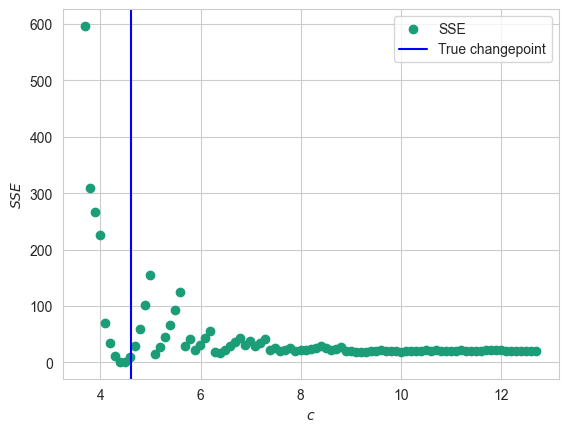

In [216]:
plt.scatter(c_values, all_Fc, label = "SSE")
plt.axvline(traj[0,1], ymin=0, ymax=500, label = "True changepoint", color = "blue")
plt.xlabel("$c$")
plt.ylabel("$SSE$")
plt.legend()

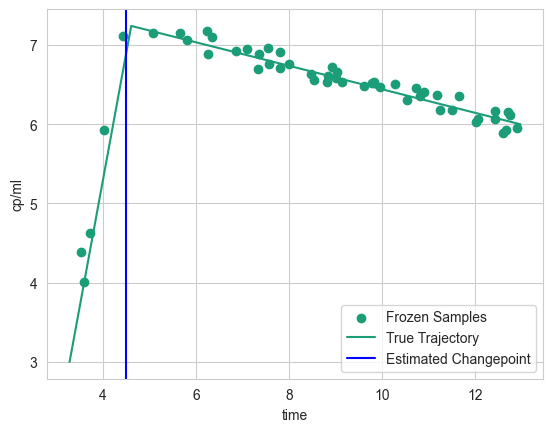

In [217]:
plt.scatter(sampled_pts[0], sampled_pts[1], zorder = 2, label = "Frozen Samples")
plt.plot(traj[0], traj[1], zorder = 1, label = "True Trajectory")
plt.axvline(changepoint, ymin=0, ymax=8, label = "Estimated Changepoint", color = "blue")
plt.xlabel("time")
plt.ylabel("cp/ml")
plt.legend()

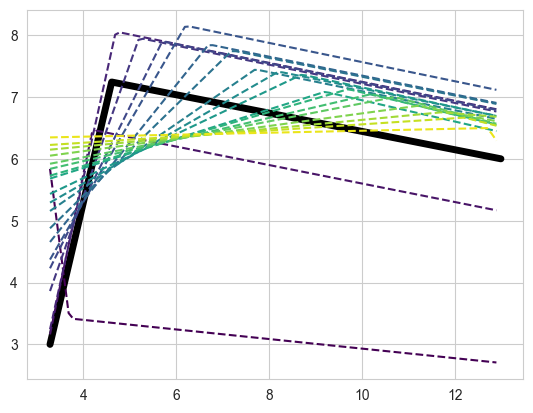

In [ ]:
colormap = plt.cm.viridis
colors_from_colormap = [colormap(j / len(c_values)) for j in range(len(c_values))]
for i in range(0, len(c_values), 5):
    pred_x = np.arange(traj[0,0], traj[0,2], 0.1)
    pred_y = set_predictor(coeffs[i, 0], coeffs[i, 1], coeffs[i,2], c_values[i], pred_x)
    plt.plot(pred_x, pred_y, zorder = 4, color= colors_from_colormap[i], label = round(c_values[i], 3), ls = "dashed")
plt.plot(traj[0], traj[1], color = "black", label = "True Trajectory", linewidth = 5)

# Simulation 2: How many samples do we need to get a good changepoint estimate?

In [222]:
sample_errors = []
num_iterations = 50
for num_samples in range(10, 100, 5):
    n_error = 0
    for iteration in range(num_iterations):
        n_error += changepoint_est_error(num_samples, 0.1)
    mean_n_error = n_error / num_iterations
    sample_errors = np.append(sample_errors, mean_n_error)

/var/folders/6s/xn5ph7893yg5wpz3m4wbcswc0000gn/T/ipykernel_88736/466771090.py:33: RuntimeWarning: invalid value encountered in scalar divide
  beta_2 = (num / denom) - beta_1


In [226]:
sample_errors2 = []
num_iterations = 500
for num_samples in range(5, 15):
    n_error = 0
    for iteration in range(num_iterations):
        n_error += changepoint_est_error(num_samples, 0.1)
    mean_n_error = n_error / num_iterations
    sample_errors2 = np.append(sample_errors2, mean_n_error)

/var/folders/6s/xn5ph7893yg5wpz3m4wbcswc0000gn/T/ipykernel_88736/466771090.py:33: RuntimeWarning: invalid value encountered in scalar divide
  beta_2 = (num / denom) - beta_1


Text(0, 0.5, 'distance from $\\hat{c}$ to true c')

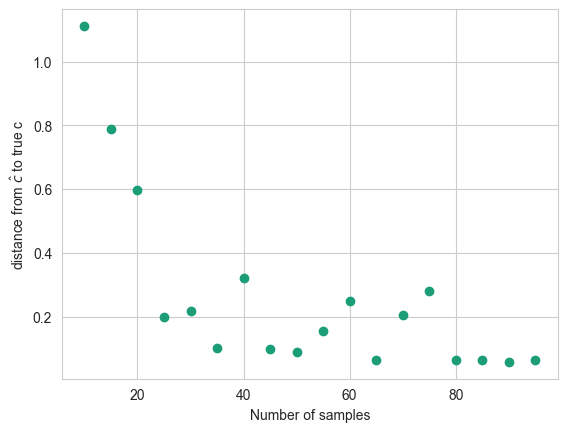

In [223]:
plt.scatter(range(10, 100, 5), sample_errors)
plt.xlabel("Number of samples")
plt.ylabel("distance from $\\hat{c}$ to true c")

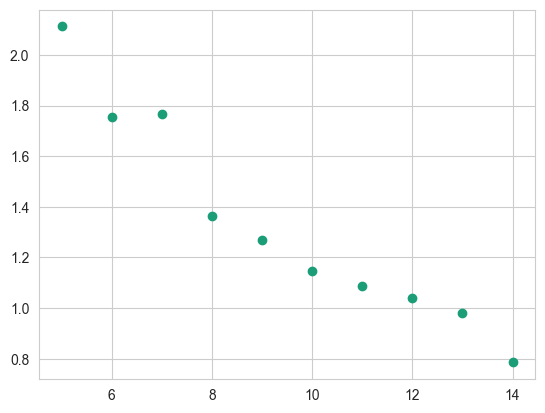

In [227]:
plt.scatter(range(5, 15), sample_errors2)

# Simulation 3: How small of a step size do we need to get a good changepoint estimate?

In [228]:
sample_errors = []
num_iterations = 20
for step_size in np.arange(0.01, 1, 0.05):
    n_error = 0
    for iteration in range(num_iterations):
        n_error += changepoint_est_error(100, step_size)
    mean_n_error = n_error / num_iterations
    sample_errors = np.append(sample_errors, mean_n_error)

/var/folders/6s/xn5ph7893yg5wpz3m4wbcswc0000gn/T/ipykernel_88736/466771090.py:33: RuntimeWarning: invalid value encountered in scalar divide
  beta_2 = (num / denom) - beta_1


Text(0, 0.5, 'distance from $\\hat{c}$ to true c')

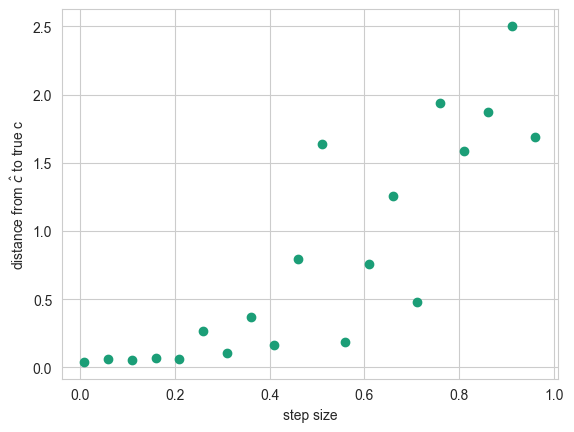

In [229]:
plt.scatter(np.arange(0.01, 1, 0.05), sample_errors)
plt.xlabel("step size")
plt.ylabel("distance from $\\hat{c}$ to true c")